In [1]:
using Pkg
Pkg.add(["DifferentialEquations", "Flux", "Plots", "MLDatasets", "OrdinaryDiffEq", "Statistics", "ForwardDiff"])

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


In [2]:
using DifferentialEquations, Flux, Plots, Random, OrdinaryDiffEq, Statistics, ForwardDiff

In [3]:
# Define the smooth ReLU function (Anderson's paper, equation 4)
function smooth_relu(y, h)
    return 0.5 * (y + sqrt(y^2 + 4h))
end

smooth_relu (generic function with 1 method)

In [4]:
# Load and preprocess MNIST data
using MLDatasets

# Loading dataset
train_x, train_y = MNIST(:train)[:]
test_x, test_y = MNIST(:test)[:]

# Preprocessing data
X_train = Flux.flatten(float.(train_x)) ./ 255
y_train = Flux.onehotbatch(train_y .+ 1, 1:10)

X_test = Flux.flatten(float.(test_x)) ./ 255
y_test = Flux.onehotbatch(test_y .+ 1, 1:10)

10×10000 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  1  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  …  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅     ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1
 1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  1     ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅

In [5]:
# Initialize CRN parameters
input_size = size(X_train, 1)
hidden_size = 40  # Match Anderson's article
output_size = 10

10

In [6]:
Random.seed!(123)
# Using standard initialization without the 2 in sqrt
W1 = randn(hidden_size, input_size) * sqrt(1 / input_size)
W2 = randn(output_size, hidden_size) * sqrt(1 / hidden_size)
# Removing the 0.01 scaling for beta as per the comment
beta1 = randn(hidden_size)
beta2 = randn(output_size)
h = 0.1  # Small activation bias

0.1

In [7]:
# Define loss function using smooth ReLU instead of leaky ReLU
function loss_function(W1, W2, beta1, beta2, X, y)
    # Apply smooth ReLU activation as defined in Anderson's paper
    hidden_activations = smooth_relu.(W1 * X .+ beta1, h)
    y_pred = softmax(W2 * hidden_activations .+ beta2)
    Flux.crossentropy(y_pred, y)
end

loss_function (generic function with 1 method)

In [8]:
# Define optimizer and initialize optimizer state
opt_state = Flux.setup(Adam(0.01), (W1, W2, beta1, beta2))

# Tableau pour enregistrer le loss
loss_history = Float64[]

# Training loop
for epoch in 1:1000
    # Define function explicitly to accept the parameters correctly
    loss_fn(W1, W2, beta1, beta2) = loss_function(W1, W2, beta1, beta2, X_train, y_train)

    # Compute gradients explicitly using separate parameters
    grads = Flux.gradient(loss_fn, W1, W2, beta1, beta2)

    # Update parameters using the correct gradients
    Flux.update!(opt_state, (W1, W2, beta1, beta2), grads)
    
    # Save the loss at each epoch
    push!(loss_history, loss_function(W1, W2, beta1, beta2, X_train, y_train))

    if epoch % 10 == 0
        println("Epoch $epoch - Loss: ", loss_function(W1, W2, beta1, beta2, X_train, y_train))
    end
end

Epoch 10 - Loss: 2.356078023244457
Epoch 20 - Loss: 2.271562966950254
Epoch 30 - Loss: 2.2456589209746505
Epoch 40 - Loss: 2.214866317985978
Epoch 50 - Loss: 2.1690351627889912
Epoch 60 - Loss: 2.1027866568639926
Epoch 70 - Loss: 2.006738699942034
Epoch 80 - Loss: 1.878642066170867
Epoch 90 - Loss: 1.7258250349454676
Epoch 100 - Loss: 1.5611919779471999
Epoch 110 - Loss: 1.3970075666103634
Epoch 120 - Loss: 1.2403330472683565
Epoch 130 - Loss: 1.0951344054135275
Epoch 140 - Loss: 0.9670689151379355
Epoch 150 - Loss: 0.8599348822185221
Epoch 160 - Loss: 0.7721178317575439
Epoch 170 - Loss: 0.7006955969070378
Epoch 180 - Loss: 0.642796087859374
Epoch 190 - Loss: 0.5956596937665986
Epoch 200 - Loss: 0.5569763432677446
Epoch 210 - Loss: 0.5248955753650582
Epoch 220 - Loss: 0.49798190846288054
Epoch 230 - Loss: 0.4751474522353858
Epoch 240 - Loss: 0.45557748692250966
Epoch 250 - Loss: 0.43865865217996447
Epoch 260 - Loss: 0.42391938454979283
Epoch 270 - Loss: 0.41098751238117537
Epoch 280 -

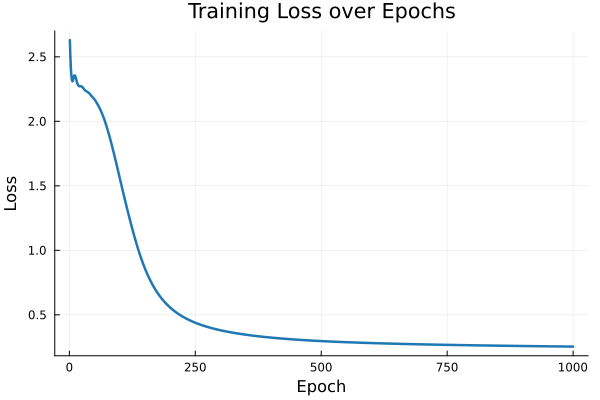

The plot has been saved to your desktop: /Users/marie/Desktop/loss_plot.png


In [22]:
# Plot the graph with a thicker line
p = plot(loss_history,
    xlabel = "Epoch",
    ylabel = "Loss",
    title = "Training Loss over Epochs",
    legend = false,
    lw = 2.5
)

#Display the plots
display(p)

# Define the path to the desktop with a fixed filename
desktop_path = joinpath(homedir(), "Desktop", "loss_plot.png")

# Save the plot
savefig(p, desktop_path)
println("The plot has been saved to your desktop: $desktop_path")

In [10]:
# Define function to use ODE solver for forward pass
function forward_pass_ode(x_input, W1, W2, beta1, beta2, h)
    # Define the complete CRN system with proper layer connections
    function full_crn_system!(dx, x, p, t)
        h, W1, W2, beta1, beta2 = p
        input_size = size(W1, 2)
        hidden_size = size(W1, 1)
        output_size = size(W2, 1)
        
        # Extract state components
        x_input_fixed = @view x[1:input_size]
        x_hidden = @view x[input_size+1:input_size+hidden_size]
        x_output = @view x[input_size+hidden_size+1:end]
        
        # Input layer is fixed
        dx[1:input_size] .= 0
        
        # Hidden layer dynamics - connected to input layer
        for i in 1:hidden_size
            input_sum = sum(W1[i,j] * x_input_fixed[j] for j in 1:input_size)
            dx[input_size+i] = h + (input_sum + beta1[i]) * x_hidden[i] - x_hidden[i]^2
        end
        
        # Output layer dynamics - connected to hidden layer
        for i in 1:output_size
            hidden_sum = sum(W2[i,j] * x_hidden[j] for j in 1:hidden_size)
            dx[input_size+hidden_size+i] = h + (hidden_sum + beta2[i]) * x_output[i] - x_output[i]^2
        end
    end
    
    # Initial state: input values, zero hidden and output states
    initial_state = vcat(x_input, zeros(hidden_size), zeros(output_size))
    params = (h, W1, W2, beta1, beta2)
    
    # Solve the ODE system
    tspan = (0.0, 10.0)  # Time span for simulation
    prob = ODEProblem(full_crn_system!, initial_state, tspan, params)
    sol = solve(prob, Tsit5(), saveat=0.5)
    
    # Return the final state of the output layer
    final_state = sol.u[end]
    output_values = final_state[input_size+hidden_size+1:end]
    
    return output_values, sol
end

forward_pass_ode (generic function with 1 method)

In [11]:
# Test on a sample image
println("Testing ODE-based forward pass on a sample image...")
test_idx = 1
test_input = X_test[:, test_idx]
true_digit = argmax(y_test[:, test_idx]) - 1

Testing ODE-based forward pass on a sample image...


7

In [12]:
# Get ODE-based prediction
output_ode, sol = forward_pass_ode(test_input, W1, W2, beta1, beta2, h)
pred_ode = argmax(output_ode) - 1
confidence_ode = softmax(output_ode)[argmax(output_ode)]

0.9942587252431275

In [13]:
# Compare with direct NN prediction
hidden_direct = smooth_relu.(W1 * test_input .+ beta1, h)
output_direct = W2 * hidden_direct .+ beta2
pred_direct = argmax(output_direct) - 1
confidence_direct = softmax(output_direct)[argmax(output_direct)]

0.9971678785839692

In [14]:
println("True digit: $true_digit")
println("ODE-based prediction: $pred_ode (confidence: $(round(confidence_ode * 100, digits=2))%)")
println("Direct NN prediction: $pred_direct (confidence: $(round(confidence_direct * 100, digits=2))%)")

True digit: 7
ODE-based prediction: 7 (confidence: 99.43%)
Direct NN prediction: 7 (confidence: 99.72%)


In [15]:
function plot_selected_dynamics(sol, input_size, hidden_size, output_size)
    # Extract time points
    t = sol.t
    
    # Extract dynamics data
    hidden_states = hcat([s[input_size+1:input_size+hidden_size] for s in sol.u]...)
    output_states = hcat([s[input_size+hidden_size+1:end] for s in sol.u]...)
    
    # Select a subset of hidden neurons to plot (e.g., 5 most active)
    mean_activity = mean(hidden_states, dims=2)[:,1]
    top_hidden_indices = sortperm(mean_activity, rev=true)[1:5]
    selected_hidden = hidden_states[top_hidden_indices, :]
    
    # Create labels for selected hidden neurons
    hidden_labels = ["Hidden $i" for i in top_hidden_indices]
    
    # Create labels for output neurons
    output_labels = ["Digit $i" for i in 0:9]
    
    # Find global max for consistent scaling
    global_max = max(maximum(selected_hidden), maximum(output_states))
    
default(lw=2, palette=:tab10)
    
# Create subplots with consistent y-axis
p1 = plot(t, selected_hidden',
          title="Selected Hidden Layer Dynamics",
          xlabel="Time",
          ylabel="Activity (Neuron State)",
          label=permutedims(hidden_labels),
          ylims=(0, 3),
          legend = :bottomright)
    
p2 = plot(t, output_states',
          title="Output Layer Dynamics",
          xlabel="Time",
          ylabel="Activity (Neuron State)",
          label=permutedims(output_labels),
          legend=:topleft, 
          ylims=(0, global_max*1.1))

# Combine plots
plot(p1, p2, layout=(2,1), size=(800,600))
end

plot_selected_dynamics (generic function with 1 method)

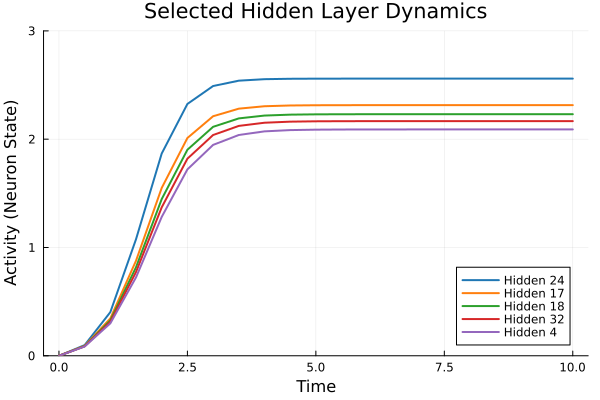

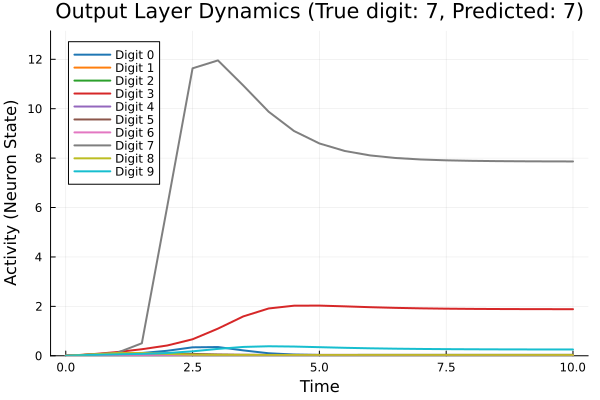

"/Users/marie/Desktop/output_layer_dynamics_predicted.png"

In [23]:
# Plot dynamics with improved visualization
p = plot_selected_dynamics(sol, input_size, hidden_size, output_size)

title!(p[2], "Output Layer Dynamics (True digit: $true_digit, Predicted: $pred_ode)")
plot1 = plot(p[1])
plot2 = plot(p[2])

#Display the plots
display(plot1)
display(plot2)

# Define the path to Desktop
desktop_path = joinpath(homedir(), "Desktop")

# Save the plot
savefig(plot1, joinpath(desktop_path, "hidden_layer_dynamics.png"))
savefig(plot2, joinpath(desktop_path, "output_layer_dynamics_predicted.png"))

In [17]:
function analyze_convergence(sol, input_size, hidden_size, output_size)
    # Extract time points and output states
    t = sol.t
    output_states = hcat([s[input_size+hidden_size+1:end] for s in sol.u]...)
    
    # Calculate softmax probabilities at each time step
    probs = hcat([softmax(output_states[:,i]) for i in 1:size(output_states, 2)]...)
    
    # Find the predicted class at each time step
    predictions = [argmax(probs[:,i]) - 1 for i in 1:size(probs, 2)]
    
    # Find stabilization point
    stable_from = findfirst(i -> all(predictions[i:end] .== predictions[end]), 1:length(predictions))
    
    # Determine time range to focus on early dynamics
    # Focus on first 30% of time steps or up to 2x stabilization point, whichever is smaller
    if !isnothing(stable_from)
        focus_until = min(ceil(Int, length(t) * 0.3), stable_from * 2)
    else
        focus_until = ceil(Int, length(t) * 0.3)
    end
    focus_until = max(focus_until, 3)  # Ensure at least 3 time points
    
    # Create two plots: one for full time range, one zoomed in
    p1 = plot(t, probs',
             title="Digit Probabilities Over Full Time Range",
             xlabel="Time",
             ylabel="Probability",
             label=permutedims(["Digit $i" for i in 0:9]),
             legend = :bottomright, 
             ylims=(0, 1.1))
    
    if !isnothing(stable_from)
        vline!(p1, [t[stable_from]], label="Stabilization point", linestyle=:dash, linewidth=2)
    end
    
    # Zoomed in on early dynamics
    p2 = plot(t[1:focus_until], probs[:,1:focus_until]',
             title="Early Dynamics (Initial Decision Phase)",
             xlabel="Time",
             ylabel="Probability",
             label=permutedims(["Digit $i" for i in 0:9]),
             ylims=(0, 1.1))
    
    # Combine plots
    plot(p1, p2, layout=(2,1), size=(600,600))
end

analyze_convergence (generic function with 1 method)

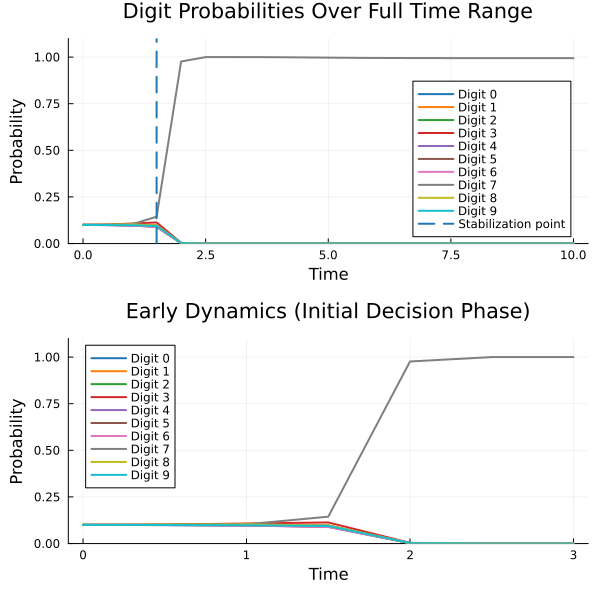

"/Users/marie/Desktop/convergence_analysis.png"

In [18]:
# Plot convergence analysis
convergence_plot = analyze_convergence(sol, input_size, hidden_size, output_size)
display(convergence_plot)
savefig(convergence_plot, joinpath(desktop_path, "convergence_analysis.png"))

In [19]:
# Plot original input image
digit_image = reshape(test_input, 28, 28)
heatmap(digit_image', 
        title="Input Digit: $true_digit",
        color=:grays,
        axis=false,
        colorbar=false)
savefig("input_digit.png")

"/Users/marie/Desktop/école/AP/input_digit.png"

In [20]:
# Evaluate on test set with both methods
function evaluate_models(X_test, y_test, W1, W2, beta1, beta2, h; num_samples=100)
    correct_ode = 0
    correct_direct = 0
    
    for i in 1:num_samples
        # Get test sample
        x = X_test[:, i]
        true_label = argmax(y_test[:, i]) - 1
        
        # ODE-based prediction
        output_ode, _ = forward_pass_ode(x, W1, W2, beta1, beta2, h)
        pred_ode = argmax(output_ode) - 1
        
        # Direct NN prediction
        hidden_direct = smooth_relu.(W1 * x .+ beta1, h)
        output_direct = W2 * hidden_direct .+ beta2
        pred_direct = argmax(output_direct) - 1
        
        # Count correct predictions
        correct_ode += (pred_ode == true_label)
        correct_direct += (pred_direct == true_label)
    end
    
    return correct_ode/num_samples, correct_direct/num_samples
end

evaluate_models (generic function with 1 method)

In [21]:
# Compare accuracy of both approaches
ode_accuracy, direct_accuracy = evaluate_models(X_test, y_test, W1, W2, beta1, beta2, h)
println("ODE-based accuracy: $(round(ode_accuracy * 100, digits=2))%")
println("Direct NN accuracy: $(round(direct_accuracy * 100, digits=2))%")
println("Difference: $(round((ode_accuracy - direct_accuracy) * 100, digits=2))%")

ODE-based accuracy: 95.0%
Direct NN accuracy: 95.0%
Difference: 0.0%
